In [1]:
import numpy as np
import matplotlib.pylab as plt
import waveletFunctions as wlf
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from scipy.io.idl import readsav
from scipy.ndimage import gaussian_filter
from scipy import signal
from sympy import *

## Analysis of synthetic signals

In [2]:
# parameters
dt = 1
N = 10**3
t = np.array([i*dt for i in range(N)])

In [3]:
def sinusoidal(A,f,t):
    return A*np.sin(2*np.pi*f*t)

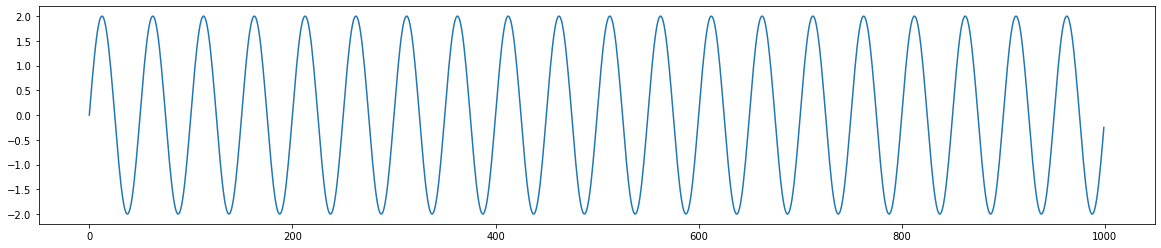

In [4]:
y= sinusoidal(2,0.02,t) # plotting an exqmple of low f

plt.figure(figsize=(20,4))
plt.plot(t,y)

In [5]:
def manual_FT(s,dt=1):
    Nmax = len(s)
    T = dt*Nmax
    
    ans = np.zeros([Nmax],dtype=complex)
    for i in range(Nmax):
        ans[i] = (1/Nmax) * np.sum([s[l]*np.exp(-(2j)*np.pi*i*l/Nmax) for l in range(Nmax)])

    
    return ans
 
    
def manual_PSD(signal,dt=1):
    u = manual_FT(signal,dt)
    Nmax = len(u)
    T = dt*Nmax
    n2 = int(Nmax/2)
    
    s = 2*T*np.abs(u[:n2])**2
    freq = [n/T for n in range(n2)]
    return freq,s
    
    
    

Text(0.5, 1.0, 'Spectral Energy Density for f = 0.02')

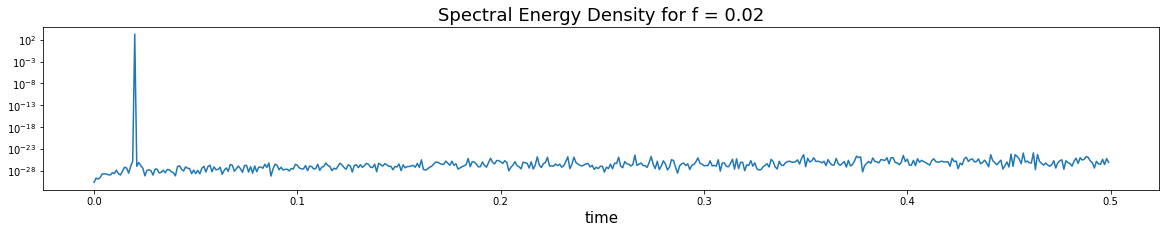

In [6]:
freq,psd = manual_PSD(y)

plt.figure(figsize=(20,3))
plt.plot(freq,psd)
plt.yscale("log")
plt.xlabel("time",fontsize=15)
plt.title("Spectral Energy Density for f = 0.02",fontsize=18)

As expected, the peak is in the assigned frequency while the other parts of the spectra have a PSD of the order <$10^{-23}$

In [7]:
# amplitude and frequency constants for sin functions
A0 = 4 
A1 = 5
f0 = 0.05
f1 = 0.005

# building y1 and y2
y_1 = sinusoidal(A0,f0,t)+sinusoidal(A1,f1,t)
y_2 = sinusoidal(A0,f0,t)
y_2[int(len(t)/2):] = sinusoidal(A1,f1,t[int(len(t)/2):])

#obtaining PSD
freq1,psd1 = manual_PSD(y_1)
freq2,psd2 = manual_PSD(y_2)

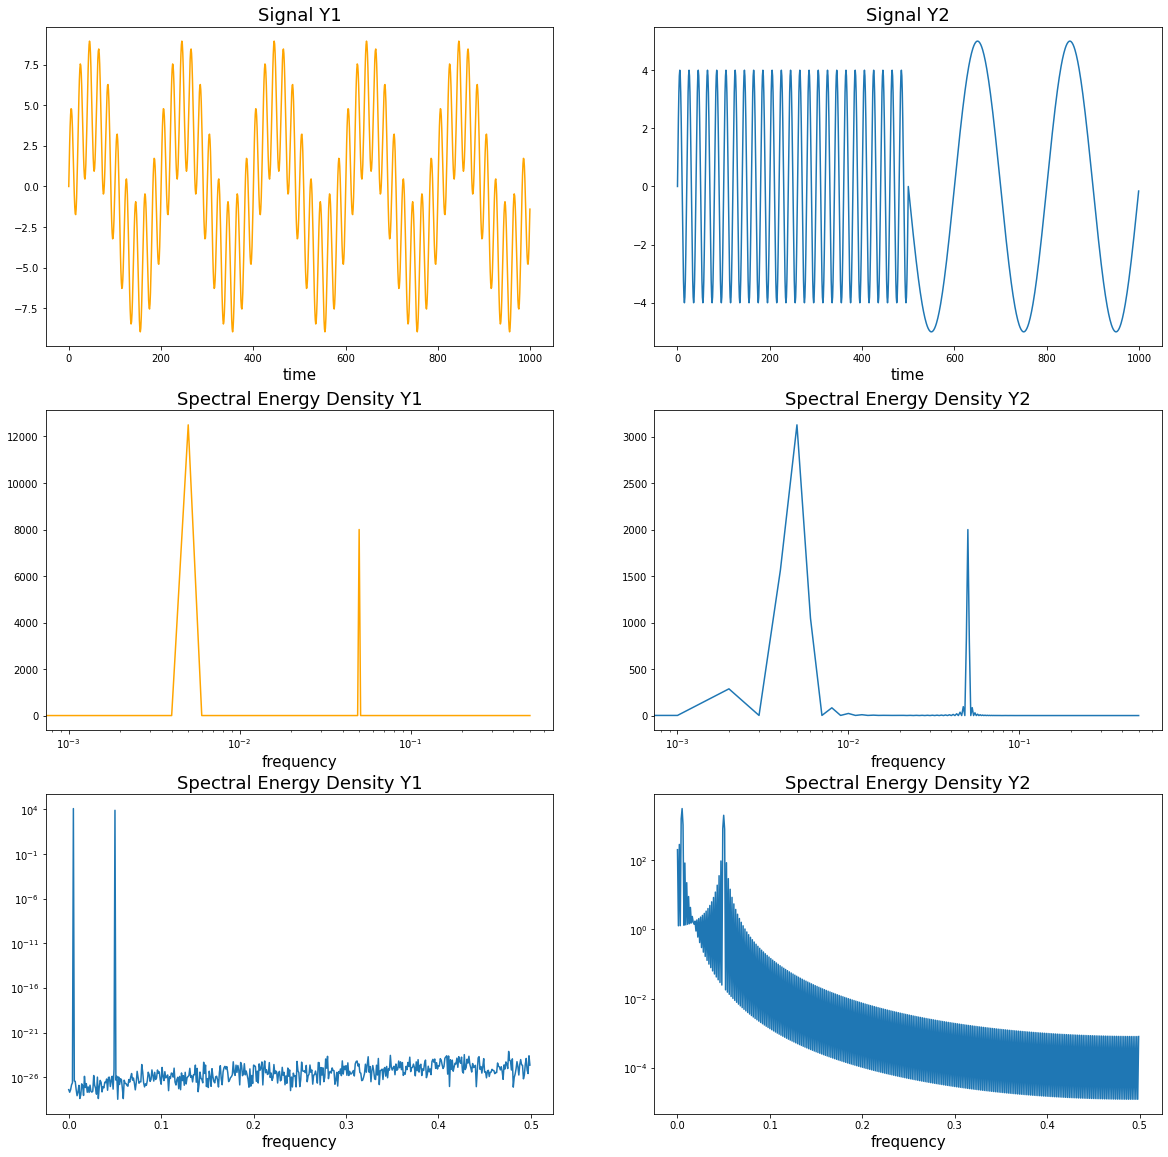

In [8]:


plt.figure(figsize=(20,20))

plt.subplot(3,2,1)
plt.title("Signal Y1",fontsize=18)
plt.plot(t,y_1,c="orange")
plt.xlabel("time",fontsize=15)


plt.subplot(3,2,3)
plt.title("Spectral Energy Density Y1",fontsize=18)
plt.plot(freq1,psd1,c="orange")
plt.xlabel("frequency",fontsize=15)
plt.xscale("log")


plt.subplot(3,2,2)
plt.title("Signal Y2",fontsize=18)
plt.plot(t,y_2)
plt.xlabel("time",fontsize=15)

plt.subplot(3,2,4)
plt.title("Spectral Energy Density Y2",fontsize=18)
plt.plot(freq2,psd2)
plt.xlabel("frequency",fontsize=15)
plt.xscale("log")

plt.subplot(3,2,5)
plt.title("Spectral Energy Density Y1",fontsize=18)
plt.plot(freq1,psd1)
plt.xlabel("frequency",fontsize=15)
plt.yscale("log")

plt.subplot(3,2,6)
plt.title("Spectral Energy Density Y2",fontsize=18)
plt.plot(freq2,psd2)
plt.xlabel("frequency",fontsize=15)
plt.yscale("log")



## wavelet transformation

### For Signal Y1

In [9]:
#time = np.arange(len(sst)) * dt + 1871.0  # construct time array
variance = np.std(y_1, ddof=1)**2
xlim = ([0, len(y_1)])  # plotting range
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.25  # this will do 4 sub-octaves per octave
s0 =  2 * dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'


# Wavelet transform:
wave, period, scale, coi = wlf.wavelet(y_1, dt, pad=pad, dj=dj, s0=s0, J1=j1, mother=mother)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / len(y_1))  # time-average over all times

# Significance levels:
signif = wlf.wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,lag1=lag1, mother=mother)
# expand signif --> (J+1)x(N) array
sig95 = signif[:, np.newaxis].dot(np.ones(len(y_1))[np.newaxis, :])
sig95 = power / sig95  # where ratio > 1, power is significant


# Global wavelet spectrum & significance levels:
dof = len(y_1) - scale  # the -scale corrects for padding at edges
global_signif = wlf.wave_signif(variance, dt=dt, scale=scale, sigtest=1,lag1=lag1, dof=dof, mother=mother)


# Scale-average between El Nino periods of 2--8 years
avg = np.logical_and(scale >= 2, scale < 8)
Cdelta = 0.776  # this is for the MORLET wavelet
# expand scale --> (J+1)x(N) array
scale_avg = scale[:, np.newaxis].dot(np.ones(len(y_1))[np.newaxis, :])
scale_avg = power / scale_avg  # [Eqn(24)]
scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wlf.wave_signif(variance, dt=dt, scale=scale, sigtest=2,
    lag1=lag1, dof=([2, 7.9]), mother=mother)

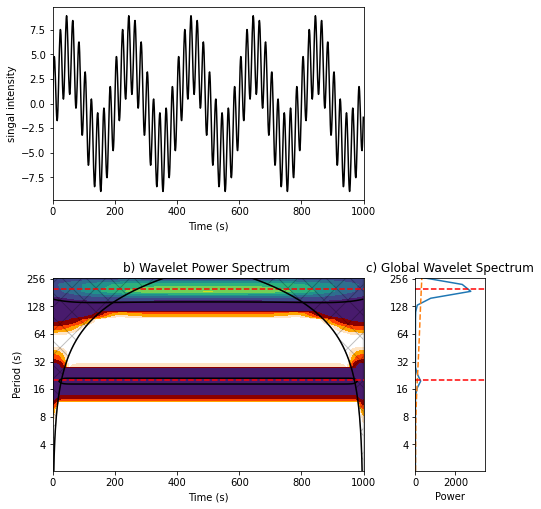

In [10]:
fig = plt.figure(figsize=(10, 12))
gs = GridSpec(3, 4, hspace=0.4, wspace=0.75)
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95,
                    wspace=0, hspace=0)
plt.subplot(gs[0, 0:3])
plt.plot(t, y_1, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (s)')
plt.ylabel('singal intensity')
#plt.title('a) NINO3 Sea Surface Temperature (seasonal)')
# --- Contour plot wavelet power spectrum
# plt3 = plt.subplot(3, 1, 2)
plt3 = plt.subplot(gs[1, 0:3])
levels = [0, 0.5, 1, 2, 4, 8]
# *** or use 'contour'
CS = plt.contourf(t, period, power, len(levels))
im = plt.contourf(CS, levels=levels,
    colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])
plt.xlabel('Time (s)')
plt.ylabel('Period (s)')
plt.title('b) Wavelet Power Spectrum ')
plt.xlim(xlim[:])
plt.axhline(1/f0,c="r",linestyle="--")
plt.axhline(1/f1,c="r",linestyle="--")
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(t, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
    edgecolor="#00000040", hatch='x')
plt.plot(t, coi, 'k')

# format y-scale
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
#plt3.invert_yaxis()
# set up the size and location of the colorbar
position=fig.add_axes([0.5,0.36,0.2,0.01])
plt.colorbar(im, cax=position, orientation='horizontal', fraction=0.05, pad=0.5)
plt.subplots_adjust(right=0.7, top=0.9)

# --- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1, -1])
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power')
plt.title('c) Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt.axhline(1/f0,c="r",linestyle="--")
plt.axhline(1/f1,c="r",linestyle="--")
#plt4.invert_yaxis()


### For signal Y2

In [11]:
#time = np.arange(len(sst)) * dt + 1871.0  # construct time array
variance = np.std(y_2, ddof=1) ** 2
xlim = ([0, len(y_2)])  # plotting range
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.25  # this will do 4 sub-octaves per octave
s0 = 2 * dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
print("lag1 = ", lag1)
mother = 'MORLET'

# Wavelet transform:
wave, period, scale, coi = wlf.wavelet(y_2, dt, pad=pad, dj=dj, s0=s0, J1=j1, mother=mother)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / len(y_2))  # time-average over all times

# Significance levels:
signif = wlf.wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,lag1=lag1, mother=mother)
# expand signif --> (J+1)x(N) array
sig95 = signif[:, np.newaxis].dot(np.ones(len(y_2))[np.newaxis, :])
sig95 = power / sig95  # where ratio > 1, power is significant


# Global wavelet spectrum & significance levels:
dof = len(y_2) - scale  # the -scale corrects for padding at edges
global_signif = wlf.wave_signif(variance, dt=dt, scale=scale, sigtest=1,lag1=lag1, dof=dof, mother=mother)


# Scale-average between El Nino periods of 2--8 years
avg = np.logical_and(scale >= 2, scale < 8)
Cdelta = 0.776  # this is for the MORLET wavelet
# expand scale --> (J+1)x(N) array
scale_avg = scale[:, np.newaxis].dot(np.ones(len(y_2))[np.newaxis, :])
scale_avg = power / scale_avg  # [Eqn(24)]
scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wlf.wave_signif(variance, dt=dt, scale=scale, sigtest=2,
    lag1=lag1, dof=([2, 7.9]), mother=mother)

lag1 =  0.72


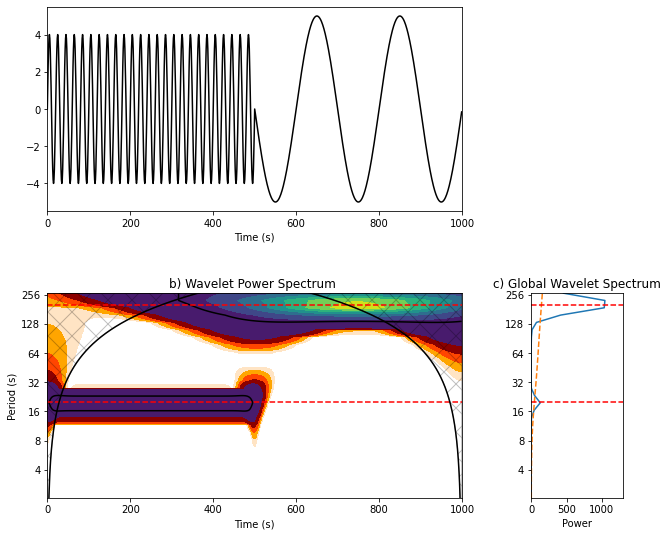

In [12]:
fig = plt.figure(figsize=(10, 12))
gs = GridSpec(3, 4, hspace=0.4, wspace=0.75)
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95,
                    wspace=0, hspace=0)
plt.subplot(gs[0, 0:3])
plt.plot(t, y_2, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (s)')
#plt.ylabel('NINO3 SST (\u00B0C)')
#plt.title('a) NINO3 Sea Surface Temperature (seasonal)')
# --- Contour plot wavelet power spectrum
# plt3 = plt.subplot(3, 1, 2)
plt3 = plt.subplot(gs[1, 0:3])
levels = [0, 0.5, 1, 2, 4, 8]
# *** or use 'contour'
CS = plt.contourf(t, period, power, len(levels))
im = plt.contourf(CS, levels=levels,
    colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])
plt.xlabel('Time (s)')
plt.ylabel('Period (s)')
plt.title('b) Wavelet Power Spectrum ')
plt.xlim(xlim[:])
plt.axhline(1/f0,c="r",linestyle="--")
plt.axhline(1/f1,c="r",linestyle="--")
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(t, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
    edgecolor="#00000040", hatch='x')
plt.plot(t, coi, 'k')

# format y-scale
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
#plt3.invert_yaxis()
# set up the size and location of the colorbar
# position=fig.add_axes([0.5,0.36,0.2,0.01])
# plt.colorbar(im, cax=position, orientation='horizontal')
#   , fraction=0.05, pad=0.5)

# plt.subplots_adjust(right=0.7, top=0.9)

# --- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1, -1])
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power')
plt.title('c) Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt.axhline(1/f0,c="r",linestyle="--")
plt.axhline(1/f1,c="r",linestyle="--")
#plt4.invert_yaxis()



## Data File

In [13]:
data = readsav("data/mix_c1_20010331.sav")
data.keys()
data["t_sc"]=data["t_sc"]-data["t_sc"][0]
data["t_dec"] = np.array([x/3600. for x in data["t_sc"]])


data["rho"] = np.sqrt(data["bx"]**2 + data["by"]**2 + data["bz"]**2 )
data["theta"] = np.arccos(data["bz"]/data["rho"])#*180/ np.pi #to degrees #np.arctan(np.sqrt(data["bx"]**2+data["by"]**2)/data["bz"])
data["phi"] = np.arctan2(data["by"],data["bx"])#*180/np.pi#[np.arctan(data["by"][i]/data["bx"][i])  for i in range(len(data["bx"])) ]
#data["phi"] = np.cos(data["phi"])
#if data["bx"][i]>=0 else np.arctan(data["by"][i]/data["bx"][i])+np.pi

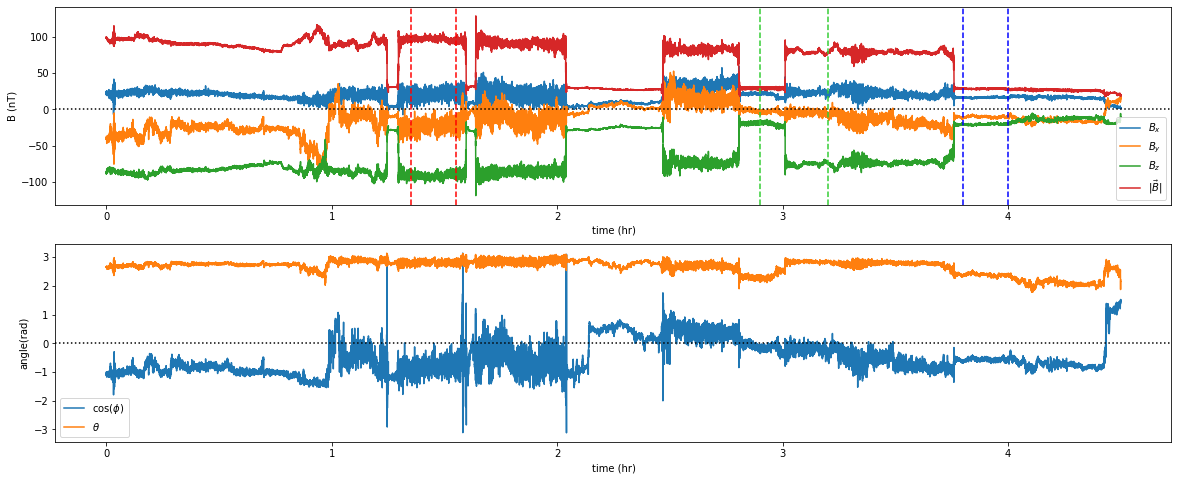

In [20]:
t_i2 = 3.8
t_f2 = 4.0

t_i3 = 2.9
t_f3 = 3.2

t_i1 = 1.35
t_f1 = 1.55
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(data["t_dec"],data["bx"],label="$B_x$")
plt.plot(data["t_dec"],data["by"],label="$B_y$")
plt.plot(data["t_dec"],data["bz"],label="$B_z$")
plt.plot(data["t_dec"],data["rho"],label="|$\\vec{B}$|")
plt.axhline(0,linestyle=":",c="k")
plt.axvline(t_i1,linestyle="--",c="r")
plt.axvline(t_f1,linestyle="--",c="r")
plt.axvline(t_i2,linestyle="--",c="b")
plt.axvline(t_f2,linestyle="--",c="b")
plt.axvline(t_i3,linestyle="--",c="limegreen")
plt.axvline(t_f3,linestyle="--",c="limegreen")
plt.xlabel("time (hr)")
plt.ylabel("B (nT)")
plt.legend(loc=4)

plt.subplot(2,1,2)
plt.plot(data["t_dec"],data["phi"],label="cos($\phi$)")
plt.plot(data["t_dec"],data["theta"],label="$\\theta$")
plt.ylabel("angle(rad)")
plt.axhline(0,linestyle=":",c="k")
plt.xlabel("time (hr)")
plt.legend()


time resolution : 0.039999993441471385 s


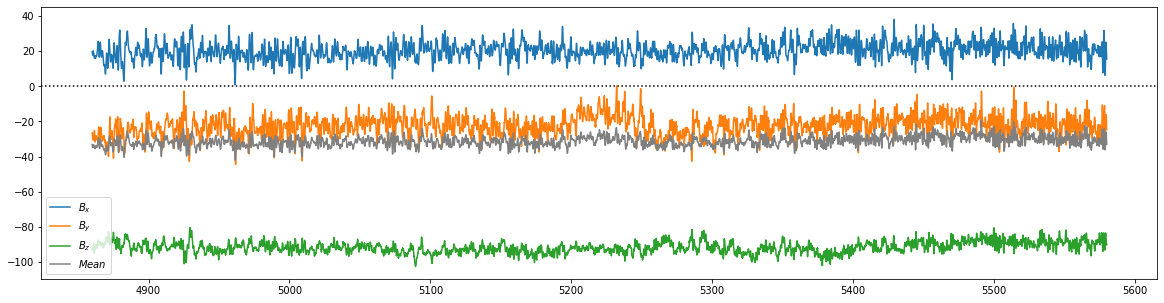

In [21]:
ii = np.logical_and(data["t_dec"]>=t_i1,data["t_dec"]<=t_f1)
dt = np.mean([(data["t_sc"][i]-data["t_sc"][i-1]) for i in range(1,len(data["t_sc"]))])
print("time resolution : {} s".format(dt))

signal_x = data["bx"][ii]
signal_y = data["by"][ii]
signal_z = data["bz"][ii]
signal_theta = data["theta"][ii]
signal_phi = data["phi"][ii]
signal_rho = data["rho"][ii]
signal_mean = (signal_x+signal_y+signal_z)/3
signal_t = data["t_sc"][ii]

n = len(signal_x)

plt.figure(figsize=(20,5))
plt.plot(signal_t,signal_x,label="$B_x$")
plt.plot(signal_t,signal_y,label="$B_y$")
plt.plot(signal_t,signal_z,label="$B_z$")
plt.plot(signal_t,signal_mean,c="grey",label="$Mean$")
plt.axhline(0,linestyle=":",c="k")
plt.legend()

### Fourier transform

In [22]:
freqs = np.fft.fftfreq(n,dt)
#ii = np.logical_and(freqs>=0,freqs<500)
ii = freqs>=0
freqs = 1/freqs[ii]
fourier_x = np.fft.fft(signal_x)[ii]
fourier_y = np.fft.fft(signal_y)[ii]
fourier_z = np.fft.fft(signal_z)[ii]
fourier_m = np.fft.fft(signal_rho)[ii]
fourier_theta = np.fft.fft(signal_theta)[ii]
fourier_phi = np.fft.fft(signal_phi)[ii]

/home/localuser/Documents/work_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


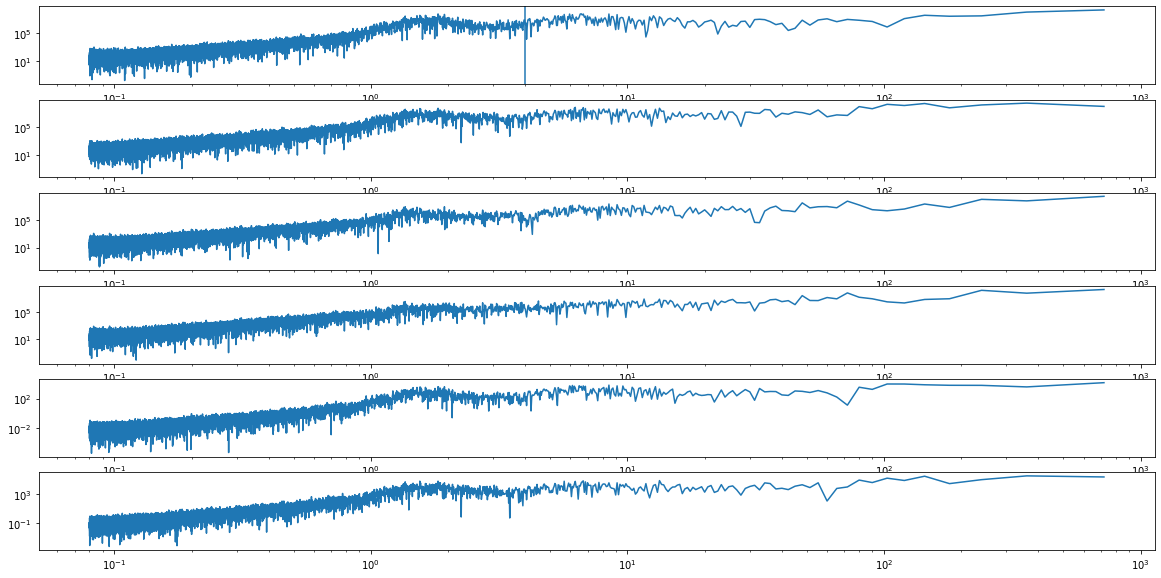

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(6,1,1)
plt.plot(freqs,np.abs(fourier_x)**2)
plt.yscale("log")
plt.xscale("log")
plt.axvline(4)
plt.subplot(6,1,2)
plt.plot(freqs,np.abs(fourier_y)**2)
plt.yscale("log")
plt.xscale("log")
plt.subplot(6,1,3)
plt.plot(freqs,np.abs(fourier_z)**2)
plt.yscale("log")
plt.xscale("log")
plt.subplot(6,1,4)
plt.plot(freqs,np.abs(fourier_m)**2)
plt.yscale("log")
plt.xscale("log")
plt.subplot(6,1,5)
plt.plot(freqs,np.abs(fourier_theta)**2)
plt.yscale("log")
plt.xscale("log")
plt.subplot(6,1,6)
plt.plot(freqs,np.abs(fourier_phi+fourier_theta)**2)
plt.yscale("log")
plt.xscale("log")


### Morlet Wavelet Analysis $B_x$

/home/localuser/Documents/work_env/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
/home/localuser/Documents/work_env/lib/python3.7/site-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


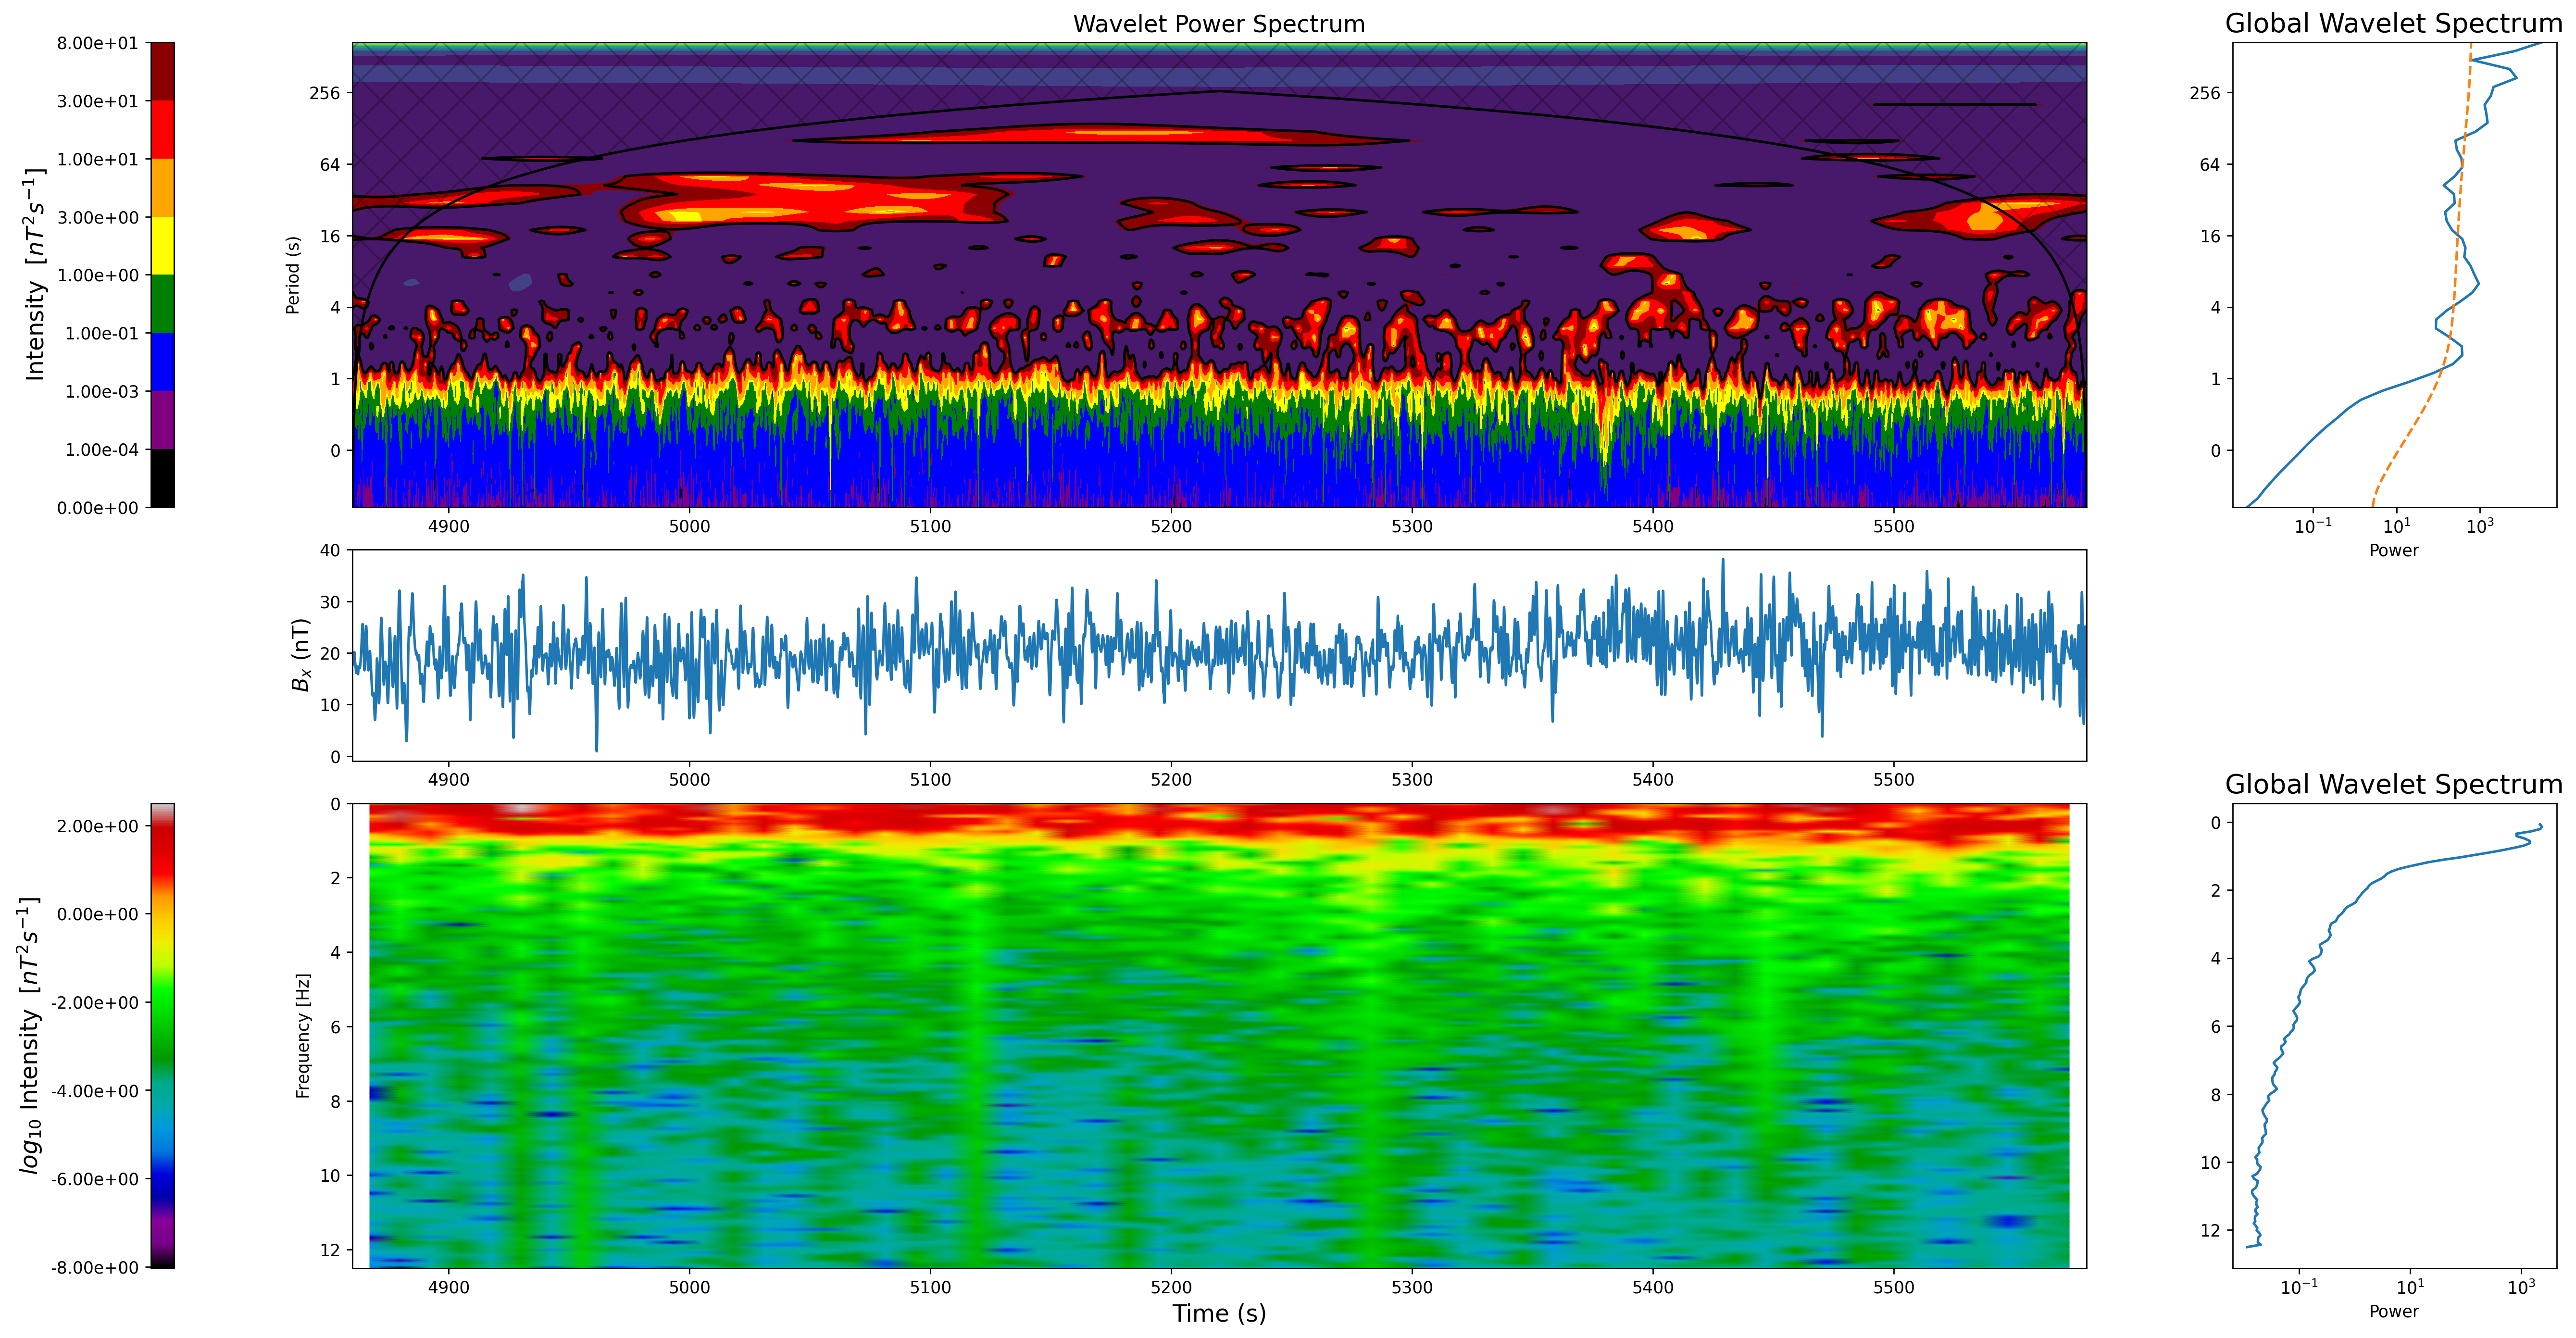

In [74]:
signalused = signal_x

wave, period, scale, coi = wlf.wavelet(signalused, dt)
t=np.arange(len(signal_t))
power = (np.abs(wave)) ** 2
lag1 = 0.8
global_ws = (np.sum(power, axis=1) / len(signalused))  # time-average over all times
variance = np.std(signalused, ddof=1) ** 2
# Significance levels:
signif = wlf.wave_signif(([variance]),scale=scale, dt=dt,mother=mother)
# expand signif --> (J+1)x(N) array
sig95 = signif[:, np.newaxis].dot(np.ones(len(signalused))[np.newaxis, :])
sig95 = power / sig95  # where ratio > 1, power is significant
# Global wavelet spectrum & significance levels:
dof = len(signalused) - scale  # the -scale corrects for padding at edges
global_signif = wlf.wave_signif(variance, dt=dt, scale=scale, sigtest=1,lag1=lag1, dof=dof, mother=mother)



##PLOTTING 


plt.figure(figsize=(25,12),dpi=250)
gs = GridSpec(5, 6, hspace=0.2, wspace=0.45)
plt.subplots_adjust(left=0.01, bottom=0.05, right=0.95, top=0.95,
                    wspace=0, hspace=0)

plt3 = plt.subplot(gs[0:2, 1:5])

levels = [0,1e-4,1e-3,0.1,1 ,3,10,30,80]
xlim = ([np.min(signal_t), np.max(signal_t)]) 

# *** or use 'contour'
CS = plt.contourf(signal_t, period, power, len(levels))
im = plt.contourf(CS, levels=levels,
    colors=['black','purple', 'blue', 'green', 'yellow',"orange","red","darkred"])

plt.ylabel('Period (s)')
plt.title('Wavelet Power Spectrum',fontsize=14)
plt.xlim(xlim[:])
#plt.axhline(1/f0,c="r",linestyle="--")
#plt.axhline(1/f1,c="r",linestyle="--")
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(signal_t, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.fill_between(signal_t, coi * 0 + period[-1], coi, facecolor="none",
    edgecolor="#00000040", hatch='x')
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')

plt.plot(signal_t, coi, 'k')
plt6 = plt.subplot(gs[0:2, 0])
plt6.axis("off")
cbar = plt.colorbar(im, orientation="vertical", fraction=0.9, location="left",pad=-0.5,format='%.2e')
cbar.set_label("Intensity  [$nT^2 s^{-1}$]",fontsize=14)
plt.subplots_adjust(right=0.9, top=0.9)

plt4 = plt.subplot(gs[0:2, -1])

plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power')
plt.title('Global Wavelet Spectrum',fontsize=16)
#plt.xlim([0, 1.25 * np.max(global_ws)])
plt.xscale("log")
# format y-scale
plt4.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')


plt5 = plt.subplot(gs[2, 1:5])
plt.plot(signal_t,signalused)
plt.xlim(xlim[:])

plt.ylabel('$B_x$ (nT)',fontsize=13)


plt6 = plt.subplot(gs[3:, 1:5])


resol = 0.02

wndw = signal.get_window("flattop",int(resol*len(signal_t)))
f, t, Sxx = signal.spectrogram(signalused,1/dt,window=wndw)
#data = gaussian_filter(Sxx,sigma=1)
im=plt.pcolormesh(t+signal_t[0], f, np.log10(Sxx+1e-16), shading='gouraud',cmap="nipy_spectral")
plt.xlabel('Time (s)')
plt.xlim(xlim[:])
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Frequency [Hz]')
plt.gca().invert_yaxis()
plt4 = plt.subplot(gs[3:, -1])
Sx = np.sum(Sxx,axis=1)
plt.plot(Sx[1:],f[1:])
plt.xlabel('Power')
plt.title('Global Wavelet Spectrum',fontsize=16)
#plt.xlim([0, 1.25 * np.max(global_ws)])
plt.xscale("log")
plt.gca().invert_yaxis()
# format y-scale

plt6 = plt.subplot(gs[3:, 0])
plt6.axis("off")
cbar = plt.colorbar(im, orientation="vertical", fraction=0.9, location="left",pad=-0.5,format='%.2e')
cbar.set_label("$log_{10}$ Intensity  [$nT^2 s^{-1}$]",fontsize=14)
plt.subplots_adjust(right=0.9, top=0.9)



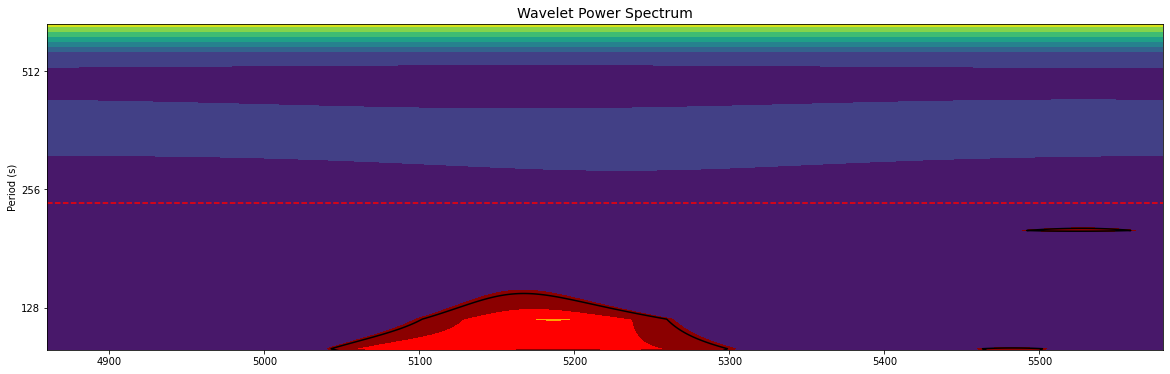

In [25]:
plt.figure(figsize=(20,6))

levels = [0,1e-4,1e-3,2e-3,5e-2 ,1,3,30,80]
xlim = ([np.min(signal_t), np.max(signal_t)]) 

# *** or use 'contour'
CS = plt.contourf(signal_t, period, power, len(levels))
im = plt.contourf(CS, levels=levels,
    colors=['black','purple', 'blue', 'green', 'yellow',"orange","red","darkred"])

plt.ylabel('Period (s)')
plt.title('Wavelet Power Spectrum',fontsize=14)
plt.xlim(xlim[:])


plt.axhline(237,c="r",linestyle="--")
#plt.axhline(1/f1,c="r",linestyle="--")
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(signal_t, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
#plt.fill_between(signal_t, coi * 0 + period[-1], coi, facecolor="none",
#    edgecolor="#00000040", hatch='x')
plt.yscale('log', base=2, subs=None)
plt.ylim([100, np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
position=fig.add_axes([0.5,0.36,0.2,0.01])
#plt.plot(signal_t, coi, 'k')

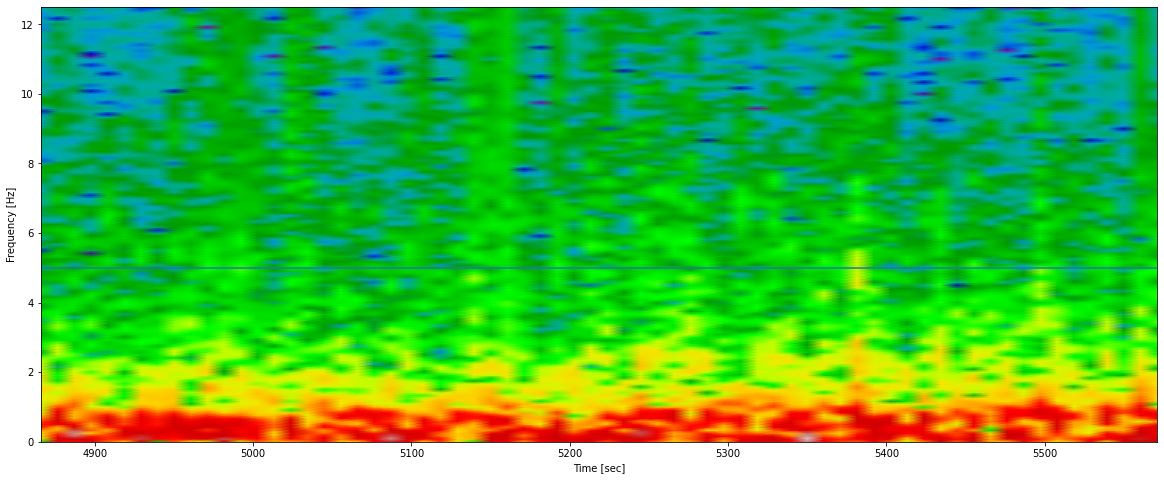

In [26]:

wndw = signal.get_window("flattop",300)
f, t, Sxx = signal.spectrogram(signal_rho,1/dt,window=wndw)

plt.figure(figsize=(20,8))
#data = gaussian_filter(Sxx,sigma=1)
plt.pcolormesh(t+signal_t[0], f, np.log10(Sxx+1e-16), shading='gouraud',cmap="nipy_spectral")


#plt.ylim(0,1)
plt.axhline(5)
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
np.min(power)

In [ ]:
Sxx.shape

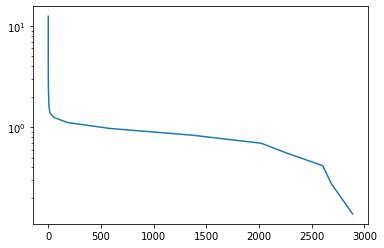

In [43]:
plt.plot(Sx[1:],f[1:])
plt.yscale("log")
#plt.xscale("log")

In [ ]:
from scipy.optimize import curve_fit

def ftrend(x,a,b,c,d):
    return a * np.exp(b*x) +x* c*np.exp(d*x) 

popt,var = curve_fit(ftrend,f[1:],Sx[1:])
yopt = ftrend(f[1:],*popt)

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
plt.plot(f[1:],Sx[1:])
plt.plot(f[1:],yopt)
plt.yscale("log")

plt.xscale("log")

plt.subplot(2,1,2)
plt.plot(f[1:],np.abs(Sx[1:]-yopt))
plt.yscale("log")

plt.xscale("log")

In [ ]:
popt

In [66]:
np.min(Sxx)

9.222027972067238e-09